# Deviation of Results from the Expectations

This document shows how much the results of the preliminary minitest (PM) deviate from the expectations marked by the IRT analysis, and especially how much the results of the final minitest (PM) deviate from the expectations marked by the IRT 

## Analysis question by question

 question  expected_total  std_dev  z_score_min  z_score_max  obs_total_pm  obs_total_fm  z_score_pm  z_score_fm  delta_z_score  IRT-PM_deviation  IRT-FM_deviation  PM-FM_deviation  p_value_pm  p_value_fm
        1          16.741 3.117969    -5.369201     7.459664            28            37    3.611005    6.497499       2.886495          0.484071          0.871018         0.386947      0.0004         0.0
        2          17.332 3.130433    -5.536615     7.241172            25            38    2.449502    6.602282       4.152781          0.338274          0.911770         0.573496      0.0114         0.0
        3          21.331 3.143980    -6.784712     5.938015            20             6   -0.423349   -4.876303      -4.452954          0.062397          0.718719         0.656322      0.3896         0.0
        4          16.009 3.098578    -5.166564     7.742585            17            39    0.319824    7.419856       7.100032          0.041307          0.958318         0.917011

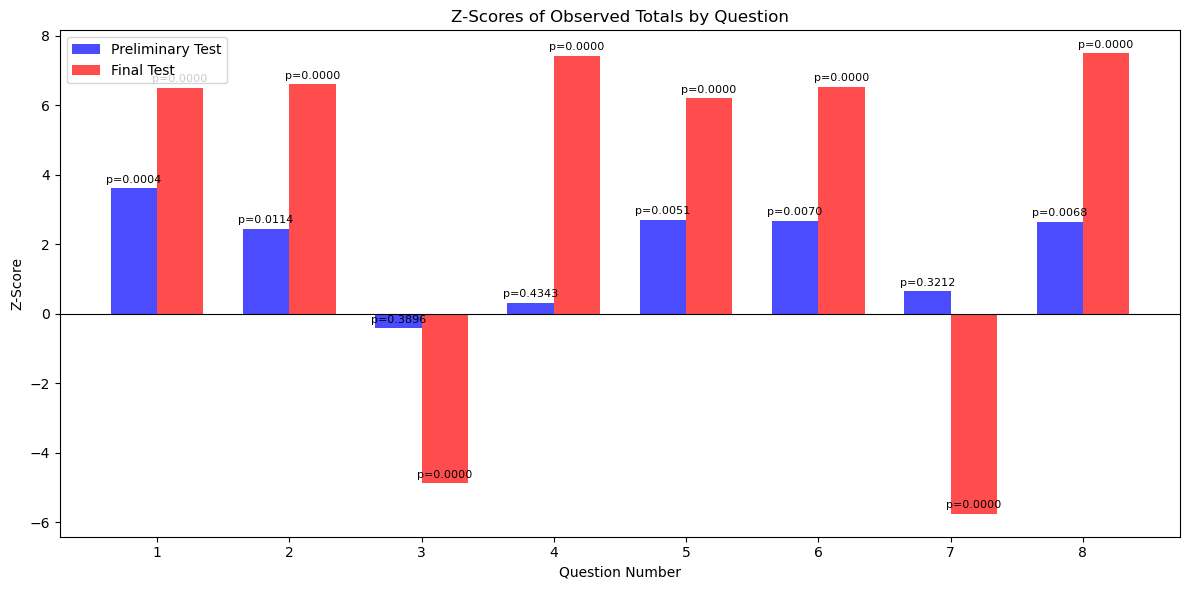

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Initialize lists to store results
results_per_question = []

def analyze_question(questionNum):
    # Get question label
    question = f'Q{questionNum}'

    # Extract probabilities for the question
    probs = data[f'{question}_prob'].values

    # Extract observed responses for preliminary and final minitests
    obs_pm = data[f'{question}_pm'].values.astype(int)
    obs_fm = data[question].values.astype(int)
    n_students = len(probs)

    # Expected total correct responses
    expected_total = probs.sum()

    # Variance and standard deviation
    variances = probs * (1 - probs)
    total_variance = variances.sum()
    std_dev = np.sqrt(total_variance)

    # Z-Score minimum and maximum
    # When all answers are wrong, z_score_min is computed as:
    z_score_min = (0 - expected_total) / std_dev
    # When all answers are correct, z_score_max is computed as:
    z_score_max = (n_students - expected_total) / std_dev

    # Observed total correct responses
    obs_total_pm = obs_pm.sum()
    obs_total_fm = obs_fm.sum()

    # Simulation for p-value
    n_simulations = 10000
    sim_totals = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_totals.append(sim_responses.sum())
    sim_totals = np.array(sim_totals)

    # P-value for preliminary minitest
    p_value_pm = np.mean(sim_totals >= obs_total_pm) if obs_total_pm >= expected_total else np.mean(sim_totals <= obs_total_pm)

    # P-value for final minitest
    p_value_fm = np.mean(sim_totals >= obs_total_fm) if obs_total_fm >= expected_total else np.mean(sim_totals <= obs_total_fm)

    # Calculate z-scores
    z_score_pm = (obs_total_pm - expected_total) / std_dev
    z_score_fm = (obs_total_fm - expected_total) / std_dev

    # Calculate change in z-scores (not absolute value)
    delta_z_score = z_score_fm - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation = z_score_fm / z_score_min if z_score_fm < 0 else z_score_fm / z_score_max
    PM_FM_deviation = delta_z_score / z_score_min if delta_z_score < 0 else delta_z_score / z_score_max

    # Store data for visualization
    results = {
        'question': questionNum,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'obs_total_pm': obs_total_pm,
        'obs_total_fm': obs_total_fm,
        'z_score_pm': z_score_pm,
        'z_score_fm': z_score_fm,
        'delta_z_score': delta_z_score,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation': IRT_FM_deviation,
        'PM-FM_deviation': PM_FM_deviation,
        'p_value_pm': p_value_pm,  # Include p_value_pm in the dictionary
        'p_value_fm': p_value_fm   # Include p_value_fm in the dictionary
    }

    return results

# Analyze each question and collect results
for q_num in range(1, 9):
    result = analyze_question(q_num)
    results_per_question.append(result)

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results_per_question)

# Display the results in the desired format
print(results_df.to_string(index=False))

# Extract z-scores and question numbers for plotting
questions = results_df['question']
z_scores_pm = results_df['z_score_pm']
z_scores_fm = results_df['z_score_fm']

# Plotting z-scores
bar_width = 0.35
index = np.arange(len(questions))

plt.figure(figsize=(12, 6))
plt.bar(index, z_scores_pm, bar_width, label='Preliminary Test', alpha=0.7, color='blue')
plt.bar(index + bar_width, z_scores_fm, bar_width, label='Final Test', alpha=0.7, color='red')

plt.xlabel('Question Number')
plt.ylabel('Z-Score')
plt.title('Z-Scores of Observed Totals by Question')
plt.xticks(index + bar_width / 2, questions)
plt.axhline(0, color='black', linewidth=0.8)

# Adding p-values as text on top of each bar
for i, (z_pm, z_fm, q_num) in enumerate(zip(z_scores_pm, z_scores_fm, questions)):
    # Check if 'p_value_pm' and 'p_value_fm' columns exist before accessing them
    if 'p_value_pm' in results_df.columns and 'p_value_fm' in results_df.columns:
        p_value_pm = results_df.iloc[i]['p_value_pm']
        p_value_fm = results_df.iloc[i]['p_value_fm']
        plt.text(i, z_pm + 0.1, f'p={p_value_pm:.4f}', ha='center', va='bottom', fontsize=8, color='black')
        plt.text(i + bar_width, z_fm + 0.1, f'p={p_value_fm:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.legend()
plt.tight_layout()
plt.show()


##### In the version below, the plot changes from zScores to deviation rate.

 question  expected_total  std_dev  z_score_min  z_score_max  obs_total_pm  obs_total_fm  z_score_pm  z_score_fm  delta_z_score  IRT-PM_deviation  IRT-FM_deviation  PM-FM_deviation  p_value_pm  p_value_fm
        1          16.741 3.117969    -5.369201     7.459664            28            37    3.611005    6.497499       2.886495          0.484071          0.871018         0.386947      0.0001         0.0
        2          17.332 3.130433    -5.536615     7.241172            25            38    2.449502    6.602282       4.152781          0.338274          0.911770         0.573496      0.0095         0.0
        3          21.331 3.143980    -6.784712     5.938015            20             6   -0.423349   -4.876303      -4.452954          0.062397          0.718719         0.656322      0.3954         0.0
        4          16.009 3.098578    -5.166564     7.742585            17            39    0.319824    7.419856       7.100032          0.041307          0.958318         0.917011

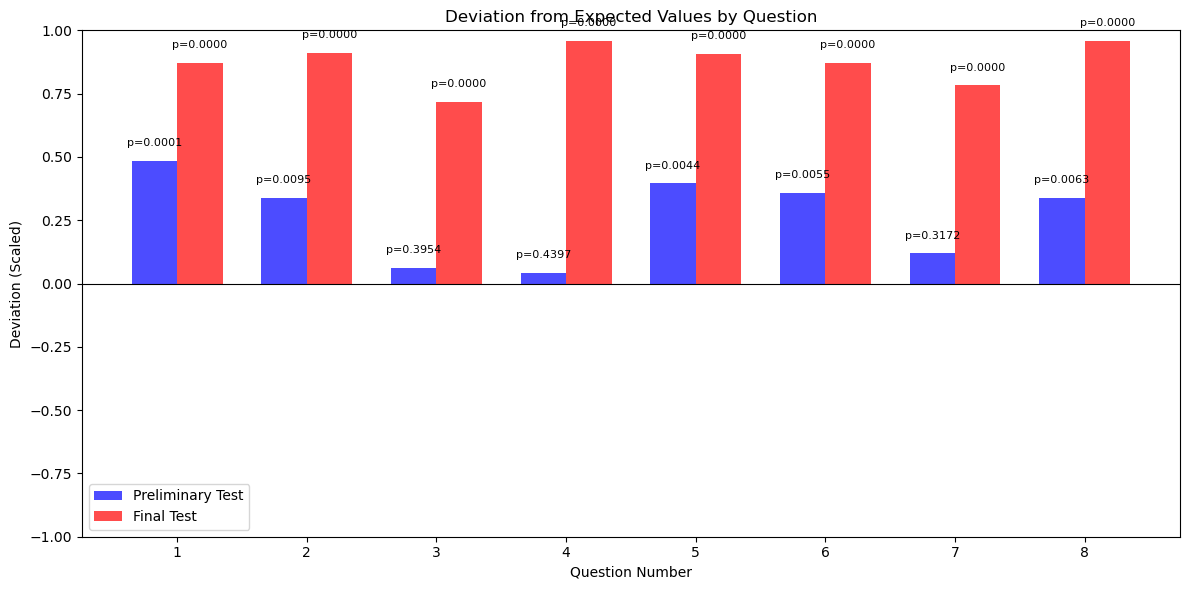

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Initialize lists to store results
results_per_question = []

def analyze_question(questionNum):
    # Get question label
    question = f'Q{questionNum}'

    # Extract probabilities for the question
    probs = data[f'{question}_prob'].values

    # Extract observed responses for preliminary and final minitests
    obs_pm = data[f'{question}_pm'].values.astype(int)
    obs_fm = data[question].values.astype(int)
    n_students = len(probs)

    # Expected total correct responses
    expected_total = probs.sum()

    # Variance and standard deviation
    variances = probs * (1 - probs)
    total_variance = variances.sum()
    std_dev = np.sqrt(total_variance)

    # Z-Score minimum and maximum
    # When all answers are wrong, z_score_min is computed as:
    z_score_min = (0 - expected_total) / std_dev
    # When all answers are correct, z_score_max is computed as:
    z_score_max = (n_students - expected_total) / std_dev

    # Observed total correct responses
    obs_total_pm = obs_pm.sum()
    obs_total_fm = obs_fm.sum()

    # Simulation for p-value
    n_simulations = 10000
    sim_totals = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_totals.append(sim_responses.sum())
    sim_totals = np.array(sim_totals)

    # P-value for preliminary minitest
    p_value_pm = np.mean(sim_totals >= obs_total_pm) if obs_total_pm >= expected_total else np.mean(sim_totals <= obs_total_pm)

    # P-value for final minitest
    p_value_fm = np.mean(sim_totals >= obs_total_fm) if obs_total_fm >= expected_total else np.mean(sim_totals <= obs_total_fm)

    # Calculate z-scores
    z_score_pm = (obs_total_pm - expected_total) / std_dev
    z_score_fm = (obs_total_fm - expected_total) / std_dev

    # Calculate change in z-scores (not absolute value)
    delta_z_score = z_score_fm - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation = z_score_fm / z_score_min if z_score_fm < 0 else z_score_fm / z_score_max
    PM_FM_deviation = delta_z_score / z_score_min if delta_z_score < 0 else delta_z_score / z_score_max

    # Store data for visualization
    results = {
        'question': questionNum,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'obs_total_pm': obs_total_pm,
        'obs_total_fm': obs_total_fm,
        'z_score_pm': z_score_pm,
        'z_score_fm': z_score_fm,
        'delta_z_score': delta_z_score,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation': IRT_FM_deviation,
        'PM-FM_deviation': PM_FM_deviation,
        'p_value_pm': p_value_pm,  # Include p_value_pm in the dictionary
        'p_value_fm': p_value_fm   # Include p_value_fm in the dictionary
    }

    return results

# Analyze each question and collect results
for q_num in range(1, 9):
    result = analyze_question(q_num)
    results_per_question.append(result)

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results_per_question)

# Display the results in the desired format
print(results_df.to_string(index=False))

# Extract deviations and question numbers for plotting
questions = results_df['question']
IRT_PM_deviation = results_df['IRT-PM_deviation']
IRT_FM_deviation = results_df['IRT-FM_deviation']

# Plotting deviations
bar_width = 0.35
index = np.arange(len(questions))

plt.figure(figsize=(12, 6))
plt.bar(index, IRT_PM_deviation, bar_width, label='Preliminary Test', alpha=0.7, color='blue')
plt.bar(index + bar_width, IRT_FM_deviation, bar_width, label='Final Test', alpha=0.7, color='red')

plt.xlabel('Question Number')
plt.ylabel('Deviation (Scaled)')
plt.title('Deviation from Expected Values by Question')
plt.xticks(index + bar_width / 2, questions)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylim(-1, 1)  # Set y-axis limits to reflect -1 to 1 scale

# Adding p-values as text on top of each bar
for i, (pm_dev, fm_dev, q_num) in enumerate(zip(IRT_PM_deviation, IRT_FM_deviation, questions)):
    p_value_pm = results_df.iloc[i]['p_value_pm']
    p_value_fm = results_df.iloc[i]['p_value_fm']
    plt.text(i, pm_dev + 0.05, f'p={p_value_pm:.4f}', ha='center', va='bottom', fontsize=8, color='black')
    plt.text(i + bar_width, fm_dev + 0.05, f'p={p_value_fm:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.legend()
plt.tight_layout()
plt.show()


### To be considered

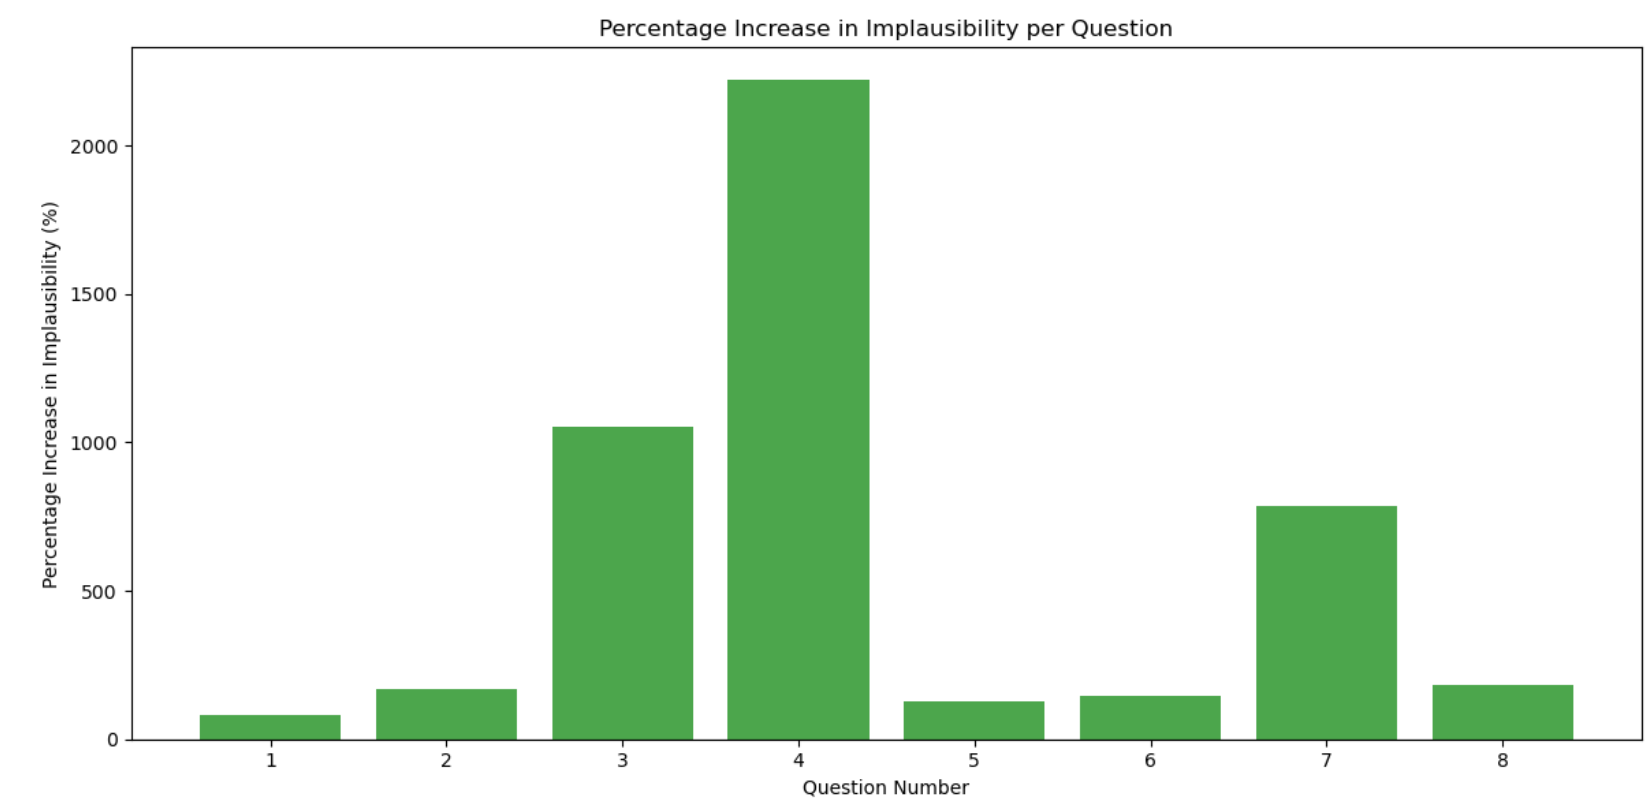

This graph was also produced by a previous version. It may be interesting, since it shows a difference between questions.

# Individual Performance Plausibility in both Preliminary and Final Minitest
Data Preparation: Reads data from CSV files and merges them into a single DataFrame.
Monte Carlo Simulation: Performs 10,000 simulations to compute expected values and confidence intervals.
Result Display: Outputs the results as a formatted table using print.
Visualization: Plots histograms to show the distribution of p-values for the Preliminary and Final Minitests.
By running this code in your environment, you'll be able to see the complete table and the visualizations as needed.

SUBJECT  Observed_Total_PM  Expected  95% CI Lower  95% CI Upper  Plausible_PM  P_Value_PM  Observed_Total_FM  Plausible_FM  P_Value_FM
     S1              0.624  0.478168         0.110      0.803000             1      0.1877              0.808             0      0.0245
     S2              0.680  0.435234         0.096      0.796000             1      0.1108              0.808             0      0.0166
     S3              0.711  0.440290         0.096      0.794000             1      0.0690              0.808             0      0.0163
     S4              0.715  0.435870         0.096      0.790000             1      0.0595              0.808             0      0.0139
     S7              0.471  0.436894         0.096      0.794000             1      0.4507              0.808             0      0.0157
     S8              0.330  0.418064         0.096      0.790000             1      0.6375              0.808             0      0.0122
     S9              0.903  0.479249         0.1

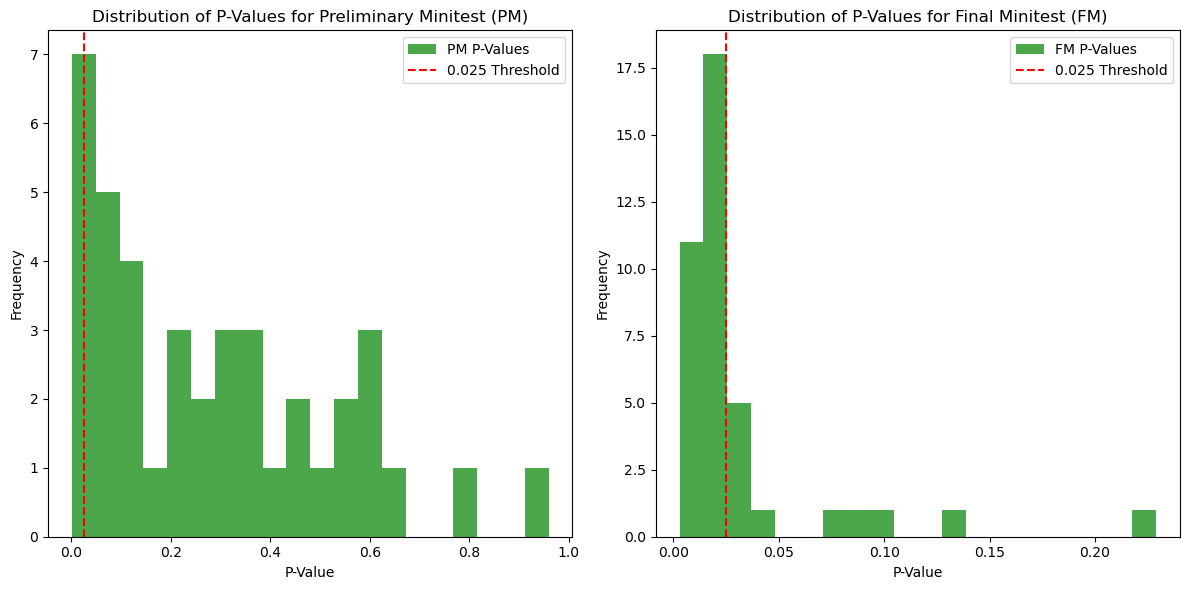

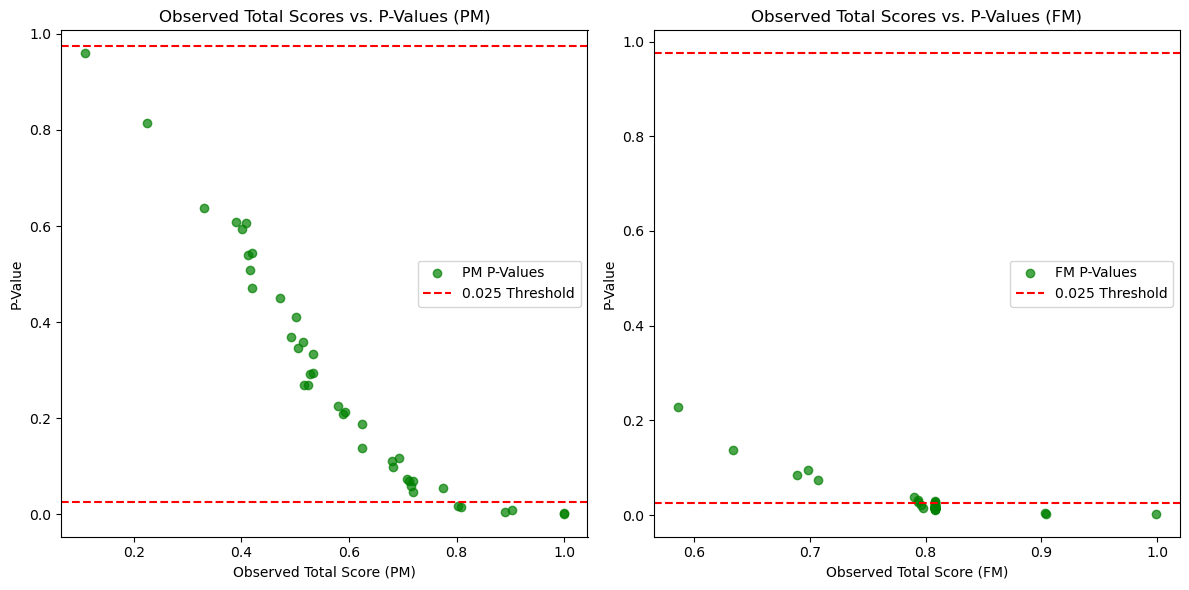

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Simulate scores once for both PM and FM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the common expected values and confidence intervals
    expected_value = np.mean(sim_totals)
    lower_bound = np.percentile(sim_totals, 2.5)
    upper_bound = np.percentile(sim_totals, 97.5)

    # Calculate p-values for PM and FM using the same simulation
    p_value_pm = np.mean(sim_totals >= observed_total_pm)
    p_value_fm = np.mean(sim_totals >= observed_total_fm)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm = 1 if p_value_pm >= 0.025 and p_value_pm <= 0.975 else 0
    plausible_fm = 1 if p_value_fm >= 0.025 and p_value_fm <= 0.975 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected': expected_value,
        '95% CI Lower': lower_bound,
        '95% CI Upper': upper_bound,
        'Plausible_PM': plausible_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM': observed_total_fm,
        'Plausible_FM': plausible_fm,
        'P_Value_FM': p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of P-Values
plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.hist(results_df['P_Value_PM'], bins=20, color='green', alpha=0.7, label='PM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Preliminary Minitest (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.hist(results_df['P_Value_FM'], bins=20, color='green', alpha=0.7, label='FM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Final Minitest (FM)')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.scatter(results_df['Observed_Total_PM'], results_df['P_Value_PM'], color='green', alpha=0.7, label='PM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (PM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.scatter(results_df['Observed_Total_FM'], results_df['P_Value_FM'], color='green', alpha=0.7, label='FM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (FM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (FM)')
plt.legend()

plt.tight_layout()
plt.show()


## Improvement of previous:

SUBJECT  Observed_Total_PM  Expected  99% CI Lower  99% CI Upper  Z_Score_PM  P_Value_PM  Observed_Total_FM_NCQ  Z_Score_FM_NCQ  P_Value_FM_NCQ  Observed_Total_FM_CQ  Z_Score_FM_CQ  P_Value_FM_CQ  Delta_Z_NCQ  Delta_Z_CQ  Percentage_Change_NCQ  Percentage_Change_CQ
     S1              0.624  0.474314      0.095000      0.903005    0.819922      0.1877                  0.904        2.353654          0.0050                 0.528       0.294071         0.3547     1.533732   -0.525851             187.058242            -64.134254
     S2              0.680  0.438184      0.000000      0.893000    1.341445      0.1156                  0.904        2.584059          0.0029                 0.584       0.808896         0.2312     1.242614   -0.532549              92.632491            -39.699639
     S3              0.711  0.440579      0.000000      0.893000    1.511966      0.0660                  0.999        3.122218          0.0013                 0.520       0.444056         0.2971     1.

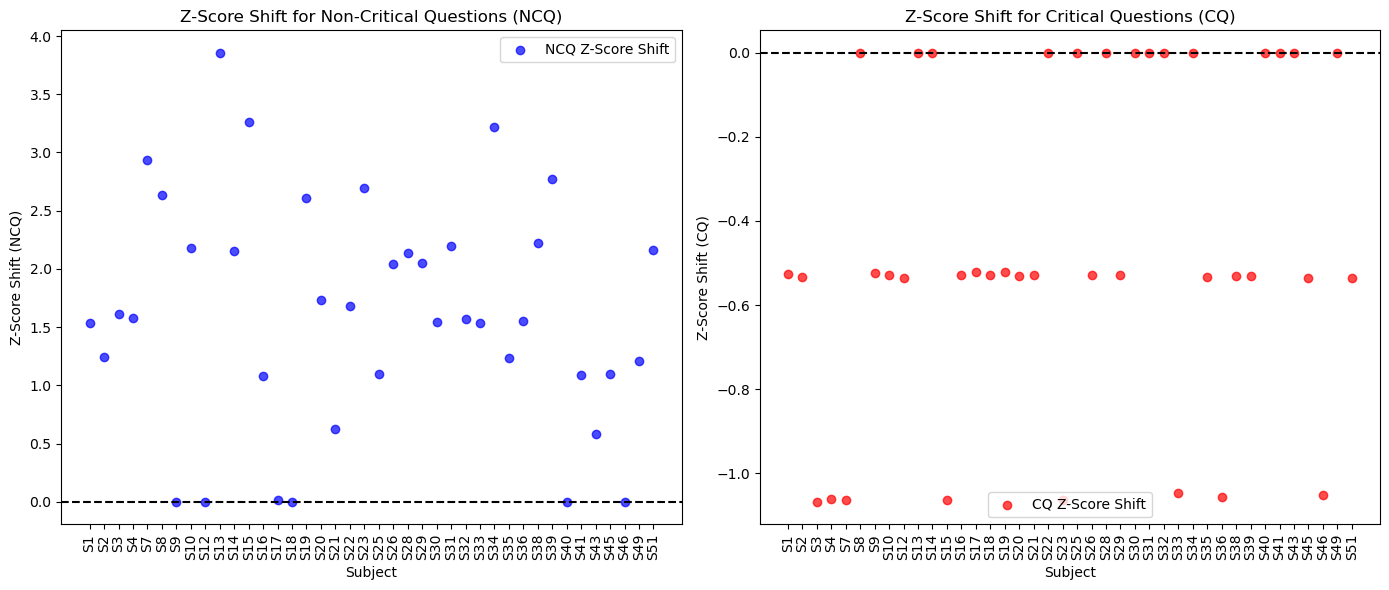

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')


# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM
    observed_total_pm = np.dot(obs_pm, question_values)

    # Simulate scores once for PM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the expected value and 99% confidence interval (instead of 95%)
    expected_value = np.mean(sim_totals)
    lower_bound = np.percentile(sim_totals, 0.5)
    upper_bound = np.percentile(sim_totals, 99.5)

    # Calculate the z-score and p-value for PM
    std_dev = np.std(sim_totals)
    z_score_pm = (observed_total_pm - expected_value) / std_dev
    p_value_pm = np.mean(sim_totals >= observed_total_pm)

    # NCQ: FM answers (correct direction) - use only NCQ indices for FM, copy PM for CQ
    obs_fm_ncq = obs_fm.copy()
    obs_fm_ncq[cq_indices] = obs_pm[cq_indices]  # Copy PM values for CQ questions
    observed_total_fm_ncq = np.dot(obs_fm_ncq, question_values)
    
    # Calculate z-score and p-value for FM (NCQ)
    z_score_fm_ncq = (observed_total_fm_ncq - expected_value) / std_dev
    p_value_fm_ncq = np.mean(sim_totals >= observed_total_fm_ncq)

    # CQ: FM answers (wrong direction) - use only CQ indices for FM, copy PM for NCQ
    obs_fm_cq = obs_fm.copy()
    obs_fm_cq[ncq_indices] = obs_pm[ncq_indices]  # Copy PM values for NCQ questions
    observed_total_fm_cq = np.dot(obs_fm_cq, question_values)
    
    # Calculate z-score and p-value for FM (CQ)
    z_score_fm_cq = (observed_total_fm_cq - expected_value) / std_dev
    p_value_fm_cq = np.mean(sim_totals >= observed_total_fm_cq)

    # Calculate z-score shifts
    delta_z_ncq = z_score_fm_ncq - z_score_pm
    delta_z_cq = z_score_fm_cq - z_score_pm

    # Percentage change in z-scores
    percentage_change_ncq = (delta_z_ncq / abs(z_score_pm)) * 100 if z_score_pm != 0 else 0
    percentage_change_cq = (delta_z_cq / abs(z_score_pm)) * 100 if z_score_pm != 0 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected': expected_value,
        '99% CI Lower': lower_bound,
        '99% CI Upper': upper_bound,
        'Z_Score_PM': z_score_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM_NCQ': observed_total_fm_ncq,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'Observed_Total_FM_CQ': observed_total_fm_cq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'P_Value_FM_CQ': p_value_fm_cq,
        'Delta_Z_NCQ': delta_z_ncq,
        'Delta_Z_CQ': delta_z_cq,
        'Percentage_Change_NCQ': percentage_change_ncq,
        'Percentage_Change_CQ': percentage_change_cq
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of Z-Score Shifts for NCQ and CQ

plt.figure(figsize=(14, 6))

# Plot Z-Score Shift for NCQ
plt.subplot(1, 2, 1)
plt.scatter(results_df['SUBJECT'], results_df['Delta_Z_NCQ'], color='blue', label='NCQ Z-Score Shift', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Subject')
plt.ylabel('Z-Score Shift (NCQ)')
plt.title('Z-Score Shift for Non-Critical Questions (NCQ)')
plt.xticks(rotation=90)
plt.legend()

# Plot Z-Score Shift for CQ
plt.subplot(1, 2, 2)
plt.scatter(results_df['SUBJECT'], results_df['Delta_Z_CQ'], color='red', label='CQ Z-Score Shift', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Subject')
plt.ylabel('Z-Score Shift (CQ)')
plt.title('Z-Score Shift for Critical Questions (CQ)')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


## HERE:

SUBJECT  expected_total  std_dev  z_score_min  z_score_max  Observed_Total_PM  Observed_Total_FM_NCQ  Observed_Total_FM_CQ  Z_Score_PM  Z_Score_FM  Z_Score_FM_NCQ  Z_Score_FM_CQ  Delta_Z_NCQ  Delta_Z_CQ  IRT-PM_deviation  IRT-FM_deviation_NCQ  IRT-FM_deviation_CQ  IRT-FM_deviation_Total  PM-FM_deviation  P_Value_PM  P_Value_FM_NCQ  P_Value_FM_CQ
     S1        0.477090 0.181868    -2.623274     2.869717              0.624                  0.904                 0.528    0.807784    1.819506        2.347361       0.279929     1.539577   -0.527855          0.281485              0.817976             0.097546                0.915522         0.634037      0.1937          0.0042         0.3594
     S2        0.437001 0.180809    -2.416924     3.108247              0.680                  0.904                 0.584    1.343953    2.051883        2.582830       0.813005     1.238877   -0.530947          0.432383              0.830960             0.261564                1.092524         0.660142

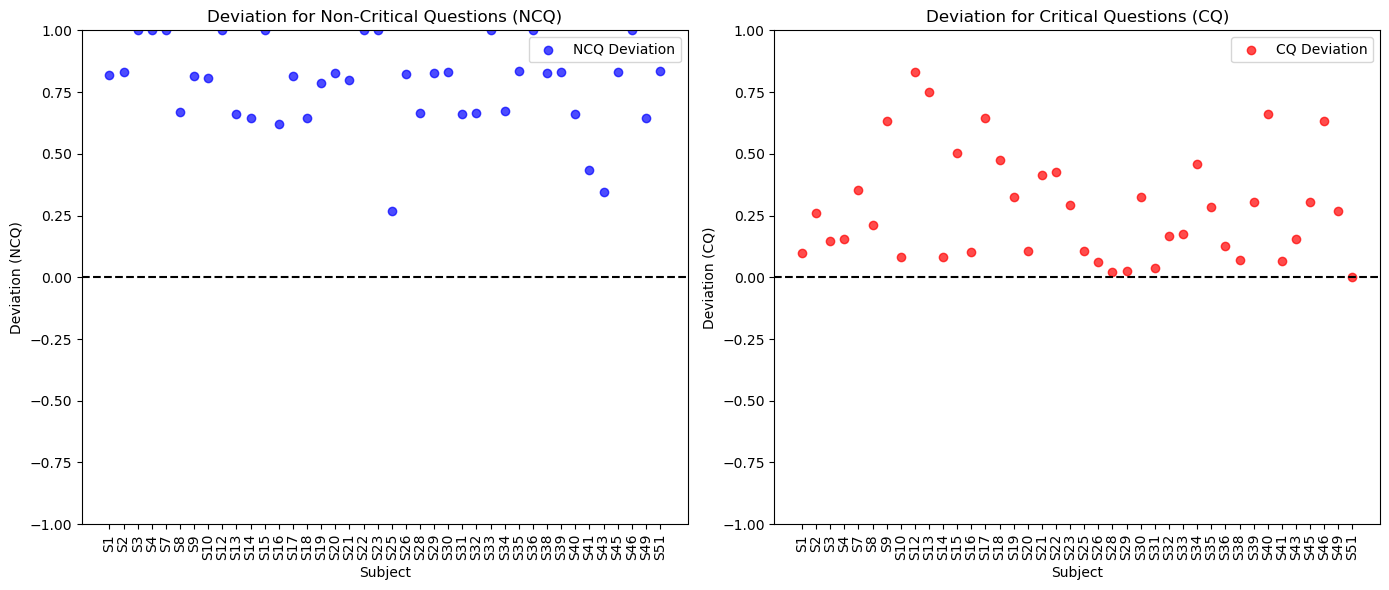

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Simulate scores once for PM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the expected value and standard deviation
    expected_value = np.mean(sim_totals)
    std_dev = np.std(sim_totals)
    z_score_min = (0 - expected_value) / std_dev  # All answers wrong
    z_score_max = (np.sum(question_values) - expected_value) / std_dev  # All answers correct

    # Calculate the z-scores and p-value for PM and FM
    z_score_pm = (observed_total_pm - expected_value) / std_dev
    z_score_fm = (observed_total_fm - expected_value) / std_dev
    p_value_pm = np.mean(sim_totals >= observed_total_pm)

    # NCQ: FM answers (correct direction) - use only NCQ indices for FM, copy PM for CQ
    obs_fm_ncq = obs_fm.copy()
    obs_fm_ncq[cq_indices] = obs_pm[cq_indices]  # Copy PM values for CQ questions
    observed_total_fm_ncq = np.dot(obs_fm_ncq, question_values)
    
    # Calculate z-score and p-value for FM (NCQ)
    z_score_fm_ncq = (observed_total_fm_ncq - expected_value) / std_dev
    p_value_fm_ncq = np.mean(sim_totals >= observed_total_fm_ncq)

    # CQ: FM answers (wrong direction) - use only CQ indices for FM, copy PM for NCQ
    obs_fm_cq = obs_fm.copy()
    obs_fm_cq[ncq_indices] = obs_pm[ncq_indices]  # Copy PM values for NCQ questions
    observed_total_fm_cq = np.dot(obs_fm_cq, question_values)
    
    # Calculate z-score and p-value for FM (CQ)
    z_score_fm_cq = (observed_total_fm_cq - expected_value) / std_dev
    p_value_fm_cq = np.mean(sim_totals >= observed_total_fm_cq)

    # Calculate z-score shifts
    delta_z_ncq = z_score_fm_ncq - z_score_pm
    delta_z_cq = z_score_fm_cq - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation_NCQ = z_score_fm_ncq / z_score_min if z_score_fm_ncq < 0 else z_score_fm_ncq / z_score_max
    IRT_FM_deviation_CQ = z_score_fm_cq / z_score_min if z_score_fm_cq < 0 else z_score_fm_cq / z_score_max
    IRT_FM_deviation_Total = IRT_FM_deviation_NCQ + IRT_FM_deviation_CQ

    # Absolute difference between FM deviation and PM deviation
    PM_FM_deviation = abs(IRT_FM_deviation_Total - IRT_PM_deviation)

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'expected_total': expected_value,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'Observed_Total_PM': observed_total_pm,
        'Observed_Total_FM_NCQ': observed_total_fm_ncq,
        'Observed_Total_FM_CQ': observed_total_fm_cq,
        'Z_Score_PM': z_score_pm,
        'Z_Score_FM': z_score_fm,  # Added new Z_Score_FM column
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'Delta_Z_NCQ': delta_z_ncq,
        'Delta_Z_CQ': delta_z_cq,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation_NCQ': IRT_FM_deviation_NCQ,
        'IRT-FM_deviation_CQ': IRT_FM_deviation_CQ,
        'IRT-FM_deviation_Total': IRT_FM_deviation_Total,
        'PM-FM_deviation': PM_FM_deviation,
        'P_Value_PM': p_value_pm,
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'P_Value_FM_CQ': p_value_fm_cq
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Reorder columns as requested
results_df = results_df[['SUBJECT', 'expected_total', 'std_dev', 'z_score_min', 'z_score_max',
                         'Observed_Total_PM', 'Observed_Total_FM_NCQ', 'Observed_Total_FM_CQ',
                         'Z_Score_PM', 'Z_Score_FM', 'Z_Score_FM_NCQ', 'Z_Score_FM_CQ',
                         'Delta_Z_NCQ', 'Delta_Z_CQ', 'IRT-PM_deviation', 'IRT-FM_deviation_NCQ',
                         'IRT-FM_deviation_CQ', 'IRT-FM_deviation_Total', 'PM-FM_deviation',
                         'P_Value_PM', 'P_Value_FM_NCQ', 'P_Value_FM_CQ']]

# Display the results
print(results_df.to_string(index=False))

# Visualization of Z-Score Shifts for NCQ and CQ

plt.figure(figsize=(14, 6))

# Plot Deviation for NCQ
plt.subplot(1, 2, 1)
plt.scatter(results_df['SUBJECT'], results_df['IRT-FM_deviation_NCQ'], color='blue', label='NCQ Deviation', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.ylim(-1, 1)
plt.xlabel('Subject')
plt.ylabel('Deviation (NCQ)')
plt.title('Deviation for Non-Critical Questions (NCQ)')
plt.xticks(rotation=90)
plt.legend()

# Plot Deviation for CQ
plt.subplot(1, 2, 2)
plt.scatter(results_df['SUBJECT'], results_df['IRT-FM_deviation_CQ'], color='red', label='CQ Deviation', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.ylim(-1, 1)
plt.xlabel('Subject')
plt.ylabel('Deviation (CQ)')
plt.title('Deviation for Critical Questions (CQ)')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Simulate scores once for PM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the expected value and standard deviation
    expected_value = np.mean(sim_totals)
    std_dev = np.std(sim_totals)
    z_score_min = (0 - expected_value) / std_dev  # All answers wrong
    z_score_max = (np.sum(question_values) - expected_value) / std_dev  # All answers correct

    # Calculate Z-Score and p-value for PM
    z_score_pm = (observed_total_pm - expected_value) / std_dev
    p_value_pm = np.mean(sim_totals >= observed_total_pm)

    # Calculate Z-Score and p-value for FM
    z_score_fm = (observed_total_fm - expected_value) / std_dev
    p_value_fm = np.mean(sim_totals >= observed_total_fm)

    # Calculate expected totals, variance, and standard deviation for NCQ and CQ separately
    expected_ncq = np.sum(probs[ncq_indices] * question_values[ncq_indices])
    variance_ncq = np.sum(probs[ncq_indices] * (1 - probs[ncq_indices]) * (question_values[ncq_indices] ** 2))
    std_dev_ncq = np.sqrt(variance_ncq)

    expected_cq = np.sum(probs[cq_indices] * question_values[cq_indices])
    variance_cq = np.sum(probs[cq_indices] * (1 - probs[cq_indices]) * (question_values[cq_indices] ** 2))
    std_dev_cq = np.sqrt(variance_cq)

    # Calculate observed totals for NCQ and CQ for PM
    observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
    observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ for PM
    z_score_pm_ncq = (observed_total_pm_ncq - expected_ncq) / std_dev_ncq
    z_score_pm_cq = (observed_total_pm_cq - expected_cq) / std_dev_cq

    # Convert z-scores to raw deviations for summation for PM
    raw_deviation_pm_ncq = (observed_total_pm_ncq - expected_ncq)
    raw_deviation_pm_cq = (observed_total_pm_cq - expected_cq)

    # Calculate summed raw deviation for PM and convert to overall z-score
    total_raw_deviation_pm = raw_deviation_pm_ncq + raw_deviation_pm_cq
    z_score_pm_verification = total_raw_deviation_pm / std_dev

    # Calculate observed totals for NCQ and CQ for FM
    observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
    observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ for FM
    z_score_fm_ncq = (observed_total_fm_ncq - expected_ncq) / std_dev_ncq
    z_score_fm_cq = (observed_total_fm_cq - expected_cq) / std_dev_cq

    # Convert z-scores to raw deviations for summation for FM
    raw_deviation_fm_ncq = (observed_total_fm_ncq - expected_ncq)
    raw_deviation_fm_cq = (observed_total_fm_cq - expected_cq)

    # Calculate summed raw deviation for FM and convert to overall z-score
    total_raw_deviation_fm = raw_deviation_fm_ncq + raw_deviation_fm_cq
    z_score_fm_verification = total_raw_deviation_fm / std_dev

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'expected_total': expected_value,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'Observed_Total_PM': observed_total_pm,
        'Z_Score_PM': z_score_pm,
        'Z_Score_PM_NCQ': z_score_pm_ncq,
        'Z_Score_PM_CQ': z_score_pm_cq,
        'Z_Score_PM_Verification': z_score_pm_verification,
        'Observed_Total_FM': observed_total_fm,
        'Z_Score_FM': z_score_fm,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'Z_Score_FM_Verification': z_score_fm_verification,
        'P_Value_PM': p_value_pm,
        'P_Value_FM': p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Reorder columns as requested
results_df = results_df[['SUBJECT', 'expected_total', 'std_dev', 'z_score_min', 'z_score_max',
                         'Observed_Total_PM', 'Z_Score_PM', 'Z_Score_PM_NCQ', 'Z_Score_PM_CQ',
                         'Z_Score_PM_Verification', 'Observed_Total_FM', 'Z_Score_FM', 'Z_Score_FM_NCQ',
                         'Z_Score_FM_CQ', 'Z_Score_FM_Verification', 'P_Value_PM', 'P_Value_FM']]

# Display the results
print(results_df.to_string(index=False))



SUBJECT  expected_total  std_dev  z_score_min  z_score_max  Observed_Total_PM  Z_Score_PM  Z_Score_PM_NCQ  Z_Score_PM_CQ  Z_Score_PM_Verification  Observed_Total_FM  Z_Score_FM  Z_Score_FM_NCQ  Z_Score_FM_CQ  Z_Score_FM_Verification  P_Value_PM  P_Value_FM
     S1        0.474699 0.180747    -2.626322     2.900751              0.624    0.826024        1.014545      -0.349963                 0.820646              0.808    1.844023        2.673499      -1.816607                 1.838645      0.1824      0.0280
     S2        0.436321 0.181106    -2.409198     3.106905              0.680    1.345507        1.495601      -0.112249                 1.344035              0.808    2.052275        2.830544      -1.540471                 2.050803      0.1124      0.0145
     S3        0.435719 0.181016    -2.407078     3.111780              0.711    1.520758        1.100685       1.276248                 1.494091              0.808    2.056623        2.815926      -1.570058                 2.029

# Approach to Analyzing Critical and Non-Critical Questions Separately:


<Figure size 1800x800 with 0 Axes>

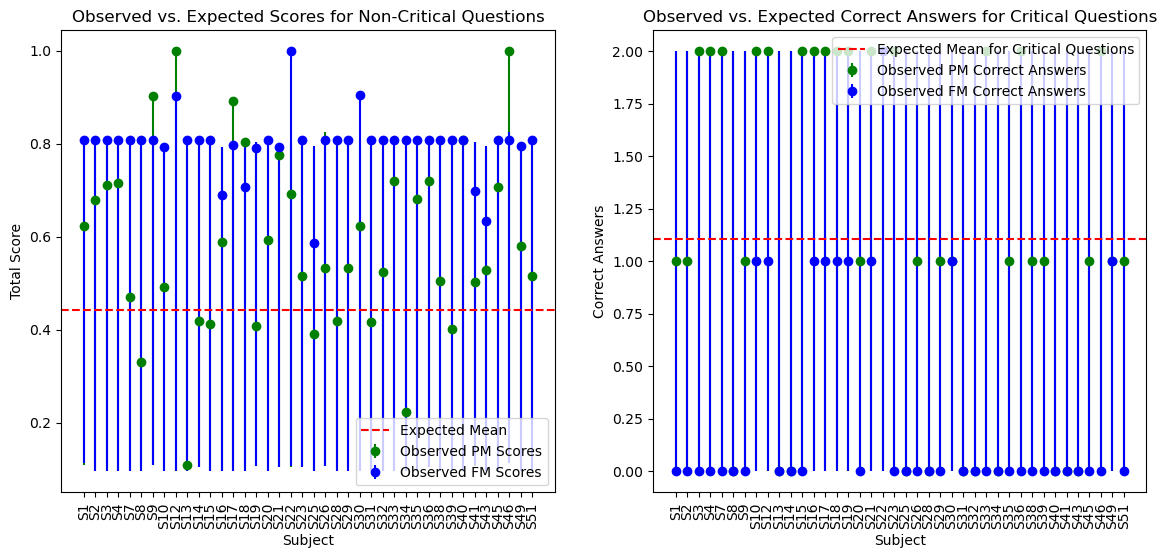

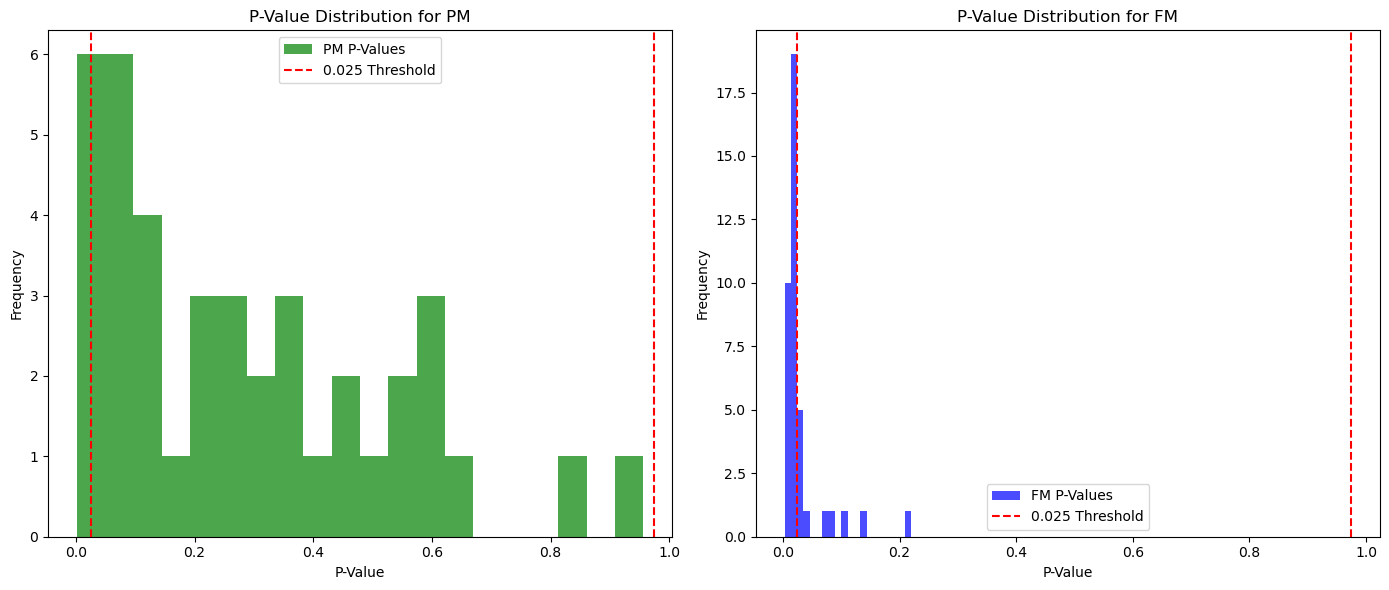

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities and observed scores for PM and FM
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Separate out the critical questions (Q3 and Q7)
    critical_indices = [2, 6]  # Q3 and Q7
    non_critical_indices = [i for i in range(8) if i not in critical_indices]

    # Observed correct answers for critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])

    # Observed total scores for non-critical questions
    observed_total_pm_non_critical = sum(obs_pm[non_critical_indices] * question_values[non_critical_indices])
    observed_total_fm_non_critical = sum(obs_fm[non_critical_indices] * question_values[non_critical_indices])

    # Simulate scores for PM and FM
    sim_totals_pm = []
    sim_totals_fm = []
    sim_correct_critical_pm = []
    sim_correct_critical_fm = []

    for _ in range(n_simulations):
        # Simulate preliminary responses
        sim_responses_pm = np.random.binomial(1, probs)
        sim_total_pm = np.dot(sim_responses_pm, question_values)
        sim_totals_pm.append(sim_total_pm)

        # For critical questions
        sim_correct_pm_critical = sum(sim_responses_pm[critical_indices])
        sim_correct_critical_pm.append(sim_correct_pm_critical)

        # Simulate final responses
        sim_responses_fm = np.random.binomial(1, probs)
        sim_total_fm = np.dot(sim_responses_fm, question_values)
        sim_totals_fm.append(sim_total_fm)

        # For critical questions
        sim_correct_fm_critical = sum(sim_responses_fm[critical_indices])
        sim_correct_critical_fm.append(sim_correct_fm_critical)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)

    # Calculate p-values
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm)

    p_value_pm_critical = np.mean(sim_correct_critical_pm >= observed_correct_pm_critical)
    p_value_fm_critical = np.mean(sim_correct_critical_fm >= observed_correct_fm_critical)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm = 1 if p_value_pm >= 0.025 and p_value_pm <= 0.975 else 0
    plausible_fm = 1 if p_value_fm >= 0.025 and p_value_fm <= 0.975 else 0
    plausible_pm_critical = 1 if p_value_pm_critical >= 0.025 and p_value_pm_critical <= 0.975 else 0
    plausible_fm_critical = 1 if p_value_fm_critical >= 0.025 and p_value_fm_critical <= 0.975 else 0

    # Calculate confidence intervals
    ci_lower_pm = np.percentile(sim_totals_pm, 2.5)
    ci_upper_pm = np.percentile(sim_totals_pm, 97.5)
    ci_lower_fm = np.percentile(sim_totals_fm, 2.5)
    ci_upper_fm = np.percentile(sim_totals_fm, 97.5)
    
    ci_lower_critical = np.percentile(sim_correct_critical_pm, 2.5)
    ci_upper_critical = np.percentile(sim_correct_critical_pm, 97.5)

    # Expected values
    expected_pm = np.mean(sim_totals_pm)
    expected_fm = np.mean(sim_totals_fm)
    expected_correct_critical = np.mean(sim_correct_critical_pm)

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected_PM': expected_pm,
        '95%_CI_Lower_PM': ci_lower_pm,
        '95%_CI_Upper_PM': ci_upper_pm,
        'Plausible_PM': plausible_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM': observed_total_fm,
        'Expected_FM': expected_fm,
        '95%_CI_Lower_FM': ci_lower_fm,
        '95%_CI_Upper_FM': ci_upper_fm,
        'Plausible_FM': plausible_fm,
        'P_Value_FM': p_value_fm,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'Expected_Correct_Critical': expected_correct_critical,
        '95% CI Lower_Critical': ci_lower_critical,
        '95% CI Upper_Critical': ci_upper_critical,
        'Plausible_PM_Critical': plausible_pm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'Plausible_FM_Critical': plausible_fm_critical,
        'P_Value_FM_Critical': p_value_fm_critical
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting functions
def plot_non_critical_questions(results_df):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)

    # Calculate non-negative yerr values
    yerr_pm = [
        np.maximum(0, results_df['Observed_Total_PM'] - results_df['95%_CI_Lower_PM']),
        np.maximum(0, results_df['95%_CI_Upper_PM'] - results_df['Observed_Total_PM'])
    ]
    yerr_fm = [
        np.maximum(0, results_df['Observed_Total_FM'] - results_df['95%_CI_Lower_FM']),
        np.maximum(0, results_df['95%_CI_Upper_FM'] - results_df['Observed_Total_FM'])
    ]

    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Total_PM'], 
                 yerr=yerr_pm, fmt='o', label='Observed PM Scores', color='green')
    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Total_FM'], 
                 yerr=yerr_fm, fmt='o', label='Observed FM Scores', color='blue')
    plt.axhline(y=results_df['Expected_PM'].mean(), color='red', linestyle='--', label='Expected Mean')
    plt.xticks(rotation=90)
    plt.xlabel('Subject')
    plt.ylabel('Total Score')
    plt.title('Observed vs. Expected Scores for Non-Critical Questions')
    plt.legend()

def plot_critical_questions(results_df):
    plt.subplot(1, 2, 2)

    # Calculate non-negative yerr values for critical questions
    yerr_pm_critical = [
        np.maximum(0, results_df['Observed_Correct_PM_Critical'] - results_df['95% CI Lower_Critical']),
        np.maximum(0, results_df['95% CI Upper_Critical'] - results_df['Observed_Correct_PM_Critical'])
    ]
    yerr_fm_critical = [
        np.maximum(0, results_df['Observed_Correct_FM_Critical'] - results_df['95% CI Lower_Critical']),
        np.maximum(0, results_df['95% CI Upper_Critical'] - results_df['Observed_Correct_FM_Critical'])
    ]

    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Correct_PM_Critical'],
                 yerr=yerr_pm_critical, fmt='o', label='Observed PM Correct Answers', color='green')
    plt.errorbar(results_df['SUBJECT'], results_df['Observed_Correct_FM_Critical'],
                 yerr=yerr_fm_critical, fmt='o', label='Observed FM Correct Answers', color='blue')
    plt.axhline(y=results_df['Expected_Correct_Critical'].mean(), color='red', linestyle='--', label='Expected Mean for Critical Questions')
    plt.xticks(rotation=90)
    plt.xlabel('Subject')
    plt.ylabel('Correct Answers')
    plt.title('Observed vs. Expected Correct Answers for Critical Questions')
    plt.legend()

def plot_p_value_distributions(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    plt.hist(results_df['P_Value_PM'], bins=20, color='green', alpha=0.7, label='PM P-Values')
    plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.axvline(0.975, color='red', linestyle='--')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.title('P-Value Distribution for PM')
    plt.legend()
    
    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    plt.hist(results_df['P_Value_FM'], bins=20, color='blue', alpha=0.7, label='FM P-Values')
    plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.axvline(0.975, color='red', linestyle='--')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.title('P-Value Distribution for FM')
    plt.legend()

def visualize_results():
    plt.figure(figsize=(18, 8))
    
    # Plot for Non-Critical Questions
    plot_non_critical_questions(results_df)

    # Plot for Critical Questions
    plot_critical_questions(results_df)

    # Plot for P-Value Distributions
    plot_p_value_distributions(results_df)

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_results()


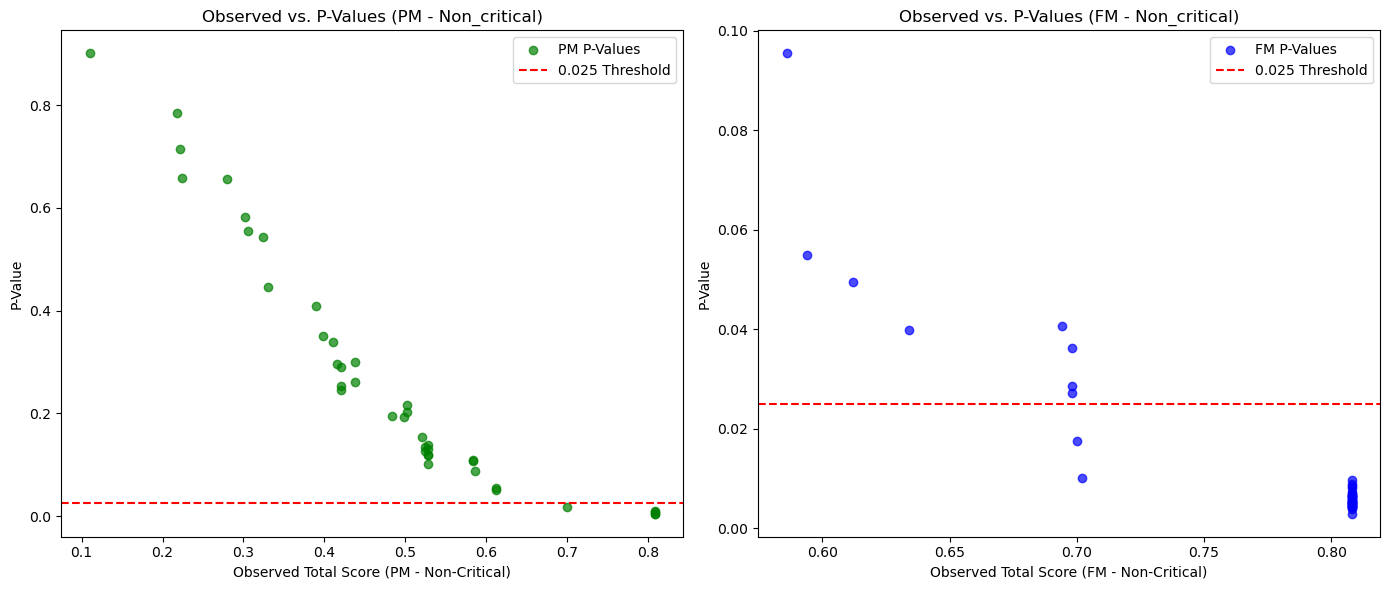

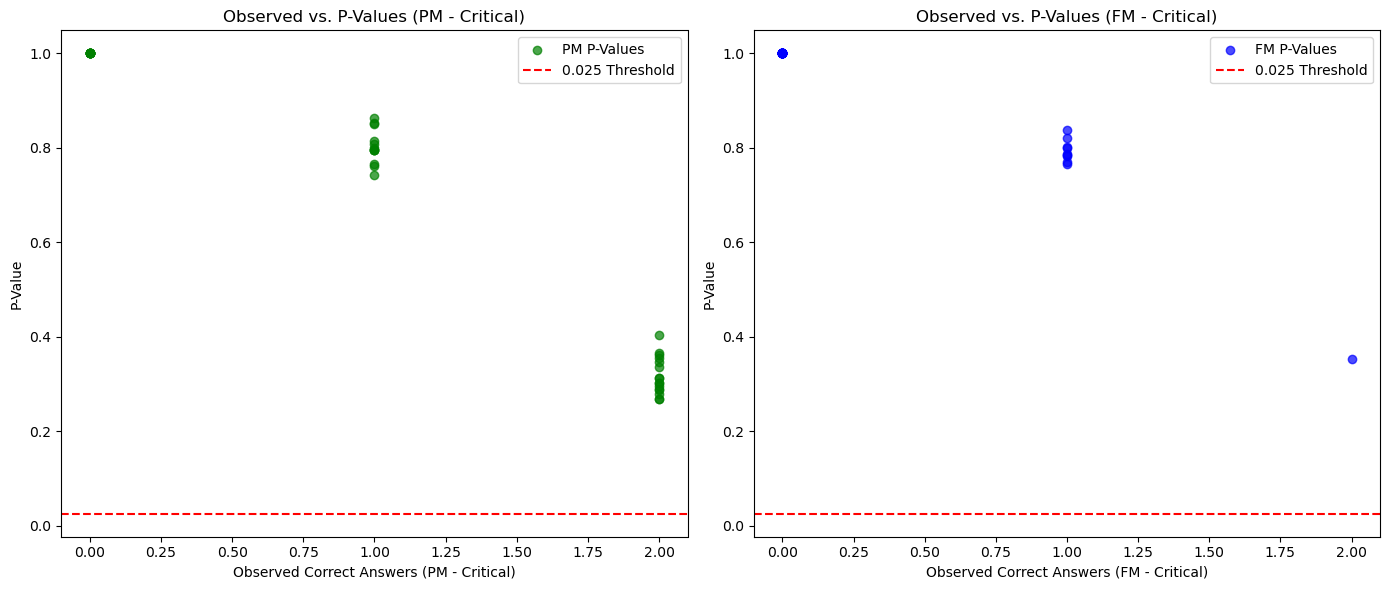

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Define question values and critical questions
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])
critical_indices = [2, 6]  # Q3 and Q7 (0-based indexing)
non_critical_indices = [i for i in range(8) if i not in critical_indices]


n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities and observed scores for PM and FM
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total scores for critical and non-critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])
    observed_total_pm_non_critical = np.dot(obs_pm[non_critical_indices], question_values[non_critical_indices])
    observed_total_fm_non_critical = np.dot(obs_fm[non_critical_indices], question_values[non_critical_indices])

    # Simulate scores for PM and FM
    sim_correct_critical_pm = []
    sim_correct_critical_fm = []
    sim_totals_pm_non_critical = []
    sim_totals_fm_non_critical = []

    for _ in range(n_simulations):
        # Simulate preliminary responses
        sim_responses_pm = np.random.binomial(1, probs)
        sim_correct_pm_critical = sum(sim_responses_pm[critical_indices])
        sim_correct_critical_pm.append(sim_correct_pm_critical)
        sim_total_pm_non_critical = np.dot(sim_responses_pm[non_critical_indices], question_values[non_critical_indices])
        sim_totals_pm_non_critical.append(sim_total_pm_non_critical)

        # Simulate final responses
        sim_responses_fm = np.random.binomial(1, probs)
        sim_correct_fm_critical = sum(sim_responses_fm[critical_indices])
        sim_correct_critical_fm.append(sim_correct_fm_critical)
        sim_total_fm_non_critical = np.dot(sim_responses_fm[non_critical_indices], question_values[non_critical_indices])
        sim_totals_fm_non_critical.append(sim_total_fm_non_critical)

    # Convert simulation results to numpy arrays
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)
    sim_totals_pm_non_critical = np.array(sim_totals_pm_non_critical)
    sim_totals_fm_non_critical = np.array(sim_totals_fm_non_critical)

    # Calculate p-values
    p_value_pm_critical = np.mean(sim_correct_critical_pm >= observed_correct_pm_critical)
    p_value_fm_critical = np.mean(sim_correct_critical_fm >= observed_correct_fm_critical)
    p_value_pm_non_critical = np.mean(sim_totals_pm_non_critical >= observed_total_pm_non_critical)
    p_value_fm_non_critical = np.mean(sim_totals_fm_non_critical >= observed_total_fm_non_critical)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm_critical = 1 if p_value_pm_critical >= 0.025 and p_value_pm_critical <= 0.975 else 0
    plausible_fm_critical = 1 if p_value_fm_critical >= 0.025 and p_value_fm_critical <= 0.975 else 0
    plausible_pm_non_critical = 1 if p_value_pm_non_critical >= 0.025 and p_value_pm_non_critical <= 0.975 else 0
    plausible_fm_non_critical = 1 if p_value_fm_non_critical >= 0.025 and p_value_fm_non_critical <= 0.975 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'Plausible_PM_Critical': plausible_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'P_Value_FM_Critical': p_value_fm_critical,
        'Plausible_FM_Critical': plausible_fm_critical,
        'Observed_Total_PM_Non_Critical': observed_total_pm_non_critical,
        'P_Value_PM_Non_Critical': p_value_pm_non_critical,
        'Plausible_PM_Non_Critical': plausible_pm_non_critical,
        'Observed_Total_FM_Non_Critical': observed_total_fm_non_critical,
        'P_Value_FM_Non_Critical': p_value_fm_non_critical,
        'Plausible_FM_Non_Critical': plausible_fm_non_critical
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


def plot_pvalues(results_df, question_type):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (PM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (PM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (PM - {question_type.capitalize()})')
    plt.legend()

    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (FM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (FM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (FM - {question_type.capitalize()})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_critical_non_critical_results():
    # Plot for Non-Critical Questions
    plot_pvalues(results_df, 'non_critical')

    # Plot for Critical Questions
    plot_pvalues(results_df, 'critical')

# Call the visualization function
visualize_critical_non_critical_results()




KeyError: 'Observed_Total_PM_Non_Critical'

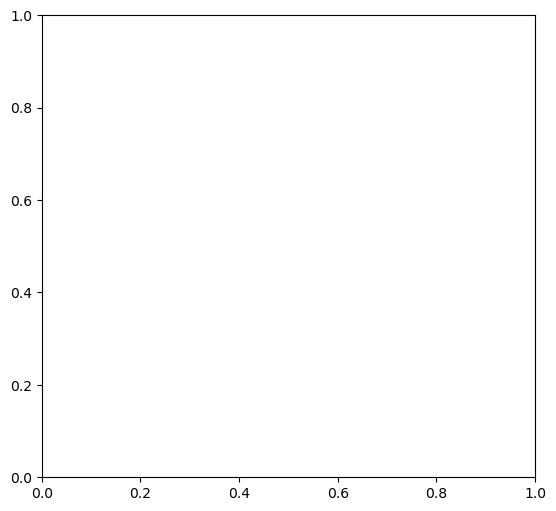

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot for Non-Critical Questions
def plot_non_critical_pvalues(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values of Non-Critical Questions
    plt.subplot(1, 2, 1)
    plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                color='green', label='PM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Total Score (PM - Non-Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Total Scores vs. P-Values (PM - Non-Critical)')
    plt.legend()
    
    # Plot for FM P-Values of Non-Critical Questions
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                color='blue', label='FM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Total Score (FM - Non-Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Total Scores vs. P-Values (FM - Non-Critical)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for Critical Questions
def plot_critical_pvalues(results_df):
    plt.figure(figsize=(14, 6))
    
    # Plot for PM P-Values of Critical Questions
    plt.subplot(1, 2, 1)
    plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                color='green', label='PM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Correct Answers (PM - Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Correct Answers vs. P-Values (PM - Critical)')
    plt.legend()
    
    # Plot for FM P-Values of Critical Questions
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                color='blue', label='FM P-Values', alpha=0.7)
    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.xlabel('Observed Correct Answers (FM - Critical)')
    plt.ylabel('P-Value')
    plt.title('Observed Correct Answers vs. P-Values (FM - Critical)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
def visualize_critical_non_critical_results():
    # Plot for Non-Critical Questions
    plot_non_critical_pvalues(results_df)
    
    # Plot for Critical Questions
    plot_critical_pvalues(results_df)
    
# Call the visualization function
visualize_critical_non_critical_results()


# _____________________________________________________
 
# Complementary analyses 
## _____________________________________________________


# Plausibility of Results  (Separately)

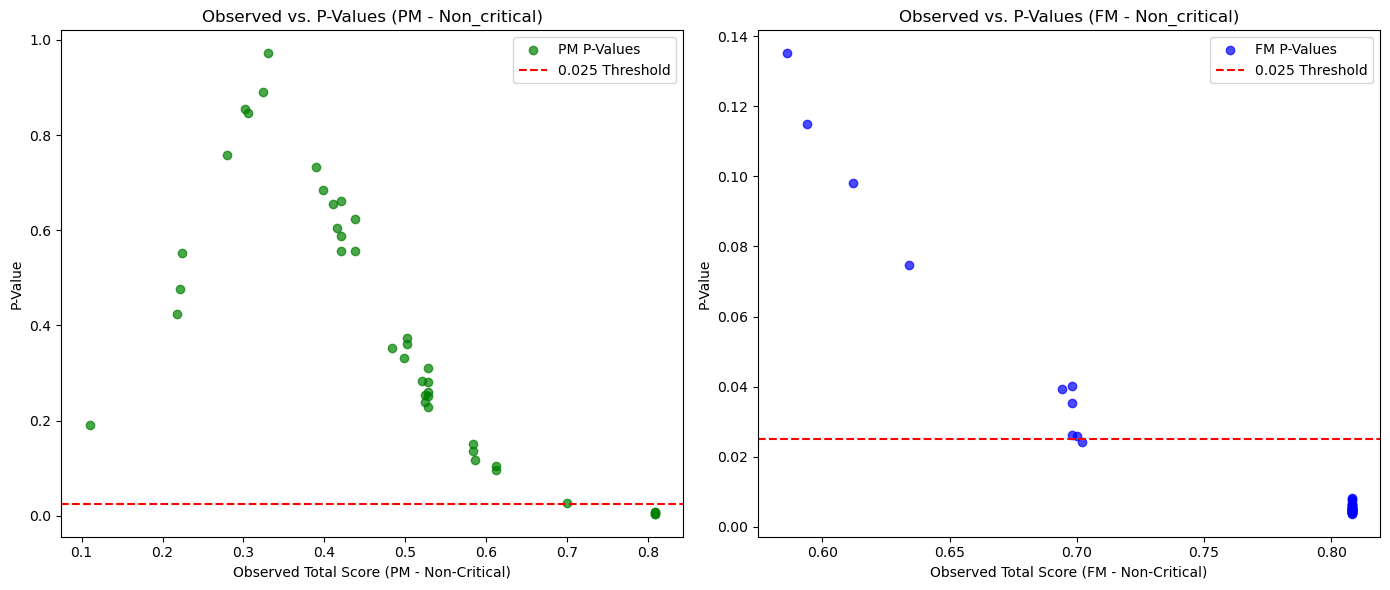

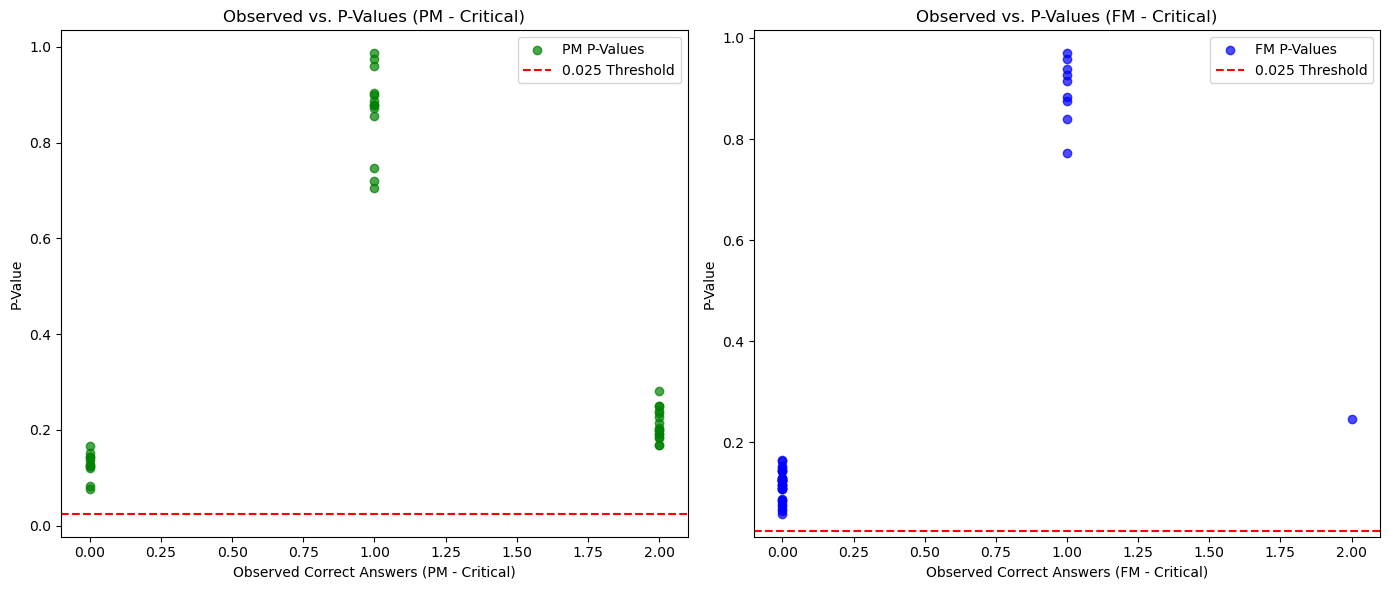

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Step 2: Define the Monte Carlo Simulation for Each Student
n_simulations = 10000
results = []

# Indices of critical and non-critical questions
critical_indices = [2, 6]  # Q3 and Q7
non_critical_indices = [i for i in range(8) if i not in critical_indices]
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Simulate results for each student
for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Observed correct answers for critical and non-critical questions
    observed_correct_pm_critical = sum(obs_pm[critical_indices])
    observed_correct_fm_critical = sum(obs_fm[critical_indices])
    observed_total_pm_non_critical = sum(obs_pm[non_critical_indices] * question_values[non_critical_indices])
    observed_total_fm_non_critical = sum(obs_fm[non_critical_indices] * question_values[non_critical_indices])

    # Simulate scores
    sim_totals_pm, sim_totals_fm, sim_correct_critical_pm, sim_correct_critical_fm = [], [], [], []

    for _ in range(n_simulations):
        sim_responses_pm = np.random.binomial(1, probs)
        sim_responses_fm = np.random.binomial(1, probs)
        sim_totals_pm.append(np.dot(sim_responses_pm[non_critical_indices], question_values[non_critical_indices]))
        sim_totals_fm.append(np.dot(sim_responses_fm[non_critical_indices], question_values[non_critical_indices]))
        sim_correct_critical_pm.append(sum(sim_responses_pm[critical_indices]))
        sim_correct_critical_fm.append(sum(sim_responses_fm[critical_indices]))

    # Convert to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_correct_critical_pm = np.array(sim_correct_critical_pm)
    sim_correct_critical_fm = np.array(sim_correct_critical_fm)

    # Calculate mean and standard deviation for normal approximation
    mean_pm_non_critical = np.mean(sim_totals_pm)
    std_pm_non_critical = np.std(sim_totals_pm)
    mean_fm_non_critical = np.mean(sim_totals_fm)
    std_fm_non_critical = np.std(sim_totals_fm)

    mean_pm_critical = np.mean(sim_correct_critical_pm)
    std_pm_critical = np.std(sim_correct_critical_pm)
    mean_fm_critical = np.mean(sim_correct_critical_fm)
    std_fm_critical = np.std(sim_correct_critical_fm)

    # Calculate z-scores for the observed values
    z_score_pm_non_critical = (observed_total_pm_non_critical - mean_pm_non_critical) / std_pm_non_critical
    z_score_fm_non_critical = (observed_total_fm_non_critical - mean_fm_non_critical) / std_fm_non_critical

    z_score_pm_critical = (observed_correct_pm_critical - mean_pm_critical) / std_pm_critical
    z_score_fm_critical = (observed_correct_fm_critical - mean_fm_critical) / std_fm_critical

    # Calculate p-values from z-scores
    p_value_pm_non_critical = 2 * (1 - norm.cdf(abs(z_score_pm_non_critical)))
    p_value_fm_non_critical = 2 * (1 - norm.cdf(abs(z_score_fm_non_critical)))

    p_value_pm_critical = 2 * (1 - norm.cdf(abs(z_score_pm_critical)))
    p_value_fm_critical = 2 * (1 - norm.cdf(abs(z_score_fm_critical)))

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM_Non_Critical': observed_total_pm_non_critical,
        'Observed_Total_FM_Non_Critical': observed_total_fm_non_critical,
        'Z_Score_PM_Non_Critical': z_score_pm_non_critical,
        'Z_Score_FM_Non_Critical': z_score_fm_non_critical,
        'P_Value_PM_Non_Critical': p_value_pm_non_critical,
        'P_Value_FM_Non_Critical': p_value_fm_non_critical,
        'Observed_Correct_PM_Critical': observed_correct_pm_critical,
        'Observed_Correct_FM_Critical': observed_correct_fm_critical,
        'Z_Score_PM_Critical': z_score_pm_critical,
        'Z_Score_FM_Critical': z_score_fm_critical,
        'P_Value_PM_Critical': p_value_pm_critical,
        'P_Value_FM_Critical': p_value_fm_critical
    })

results_df = pd.DataFrame(results)

# Step 4: Visualize the Results
def plot_p_values(results_df, question_type):
    plt.figure(figsize=(14, 6))

    # Plot for PM P-Values
    plt.subplot(1, 2, 1)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_PM_Non_Critical'], results_df['P_Value_PM_Non_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (PM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_PM_Critical'], results_df['P_Value_PM_Critical'], 
                    color='green', label='PM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (PM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (PM - {question_type.capitalize()})')
    plt.legend()

    # Plot for FM P-Values
    plt.subplot(1, 2, 2)
    if question_type == 'non_critical':
        plt.scatter(results_df['Observed_Total_FM_Non_Critical'], results_df['P_Value_FM_Non_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Total Score (FM - Non-Critical)')
    else:
        plt.scatter(results_df['Observed_Correct_FM_Critical'], results_df['P_Value_FM_Critical'], 
                    color='blue', label='FM P-Values', alpha=0.7)
        plt.xlabel('Observed Correct Answers (FM - Critical)')

    plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
    plt.ylabel('P-Value')
    plt.title(f'Observed vs. P-Values (FM - {question_type.capitalize()})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 5: Visualize Results for Both Non-Critical and Critical Questions
def visualize_results():
    # Plot for Non-Critical Questions
    plot_p_values(results_df, 'non_critical')

    # Plot for Critical Questions
    plot_p_values(results_df, 'critical')

# Call the visualization function
visualize_results()
